In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras import layers, optimizers
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
#  Unzip and Load the Dataset
from zipfile import ZipFile
zip_file_path = '../dataset/UTKFace.zip'
extract_to_path = '../dataset' 

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print("File unzipped successfully!")

In [3]:
# Load Dataset
path = '../dataset/UTKFace'
file_list = os.listdir(path)
print("Number of Images: ", len(file_list))

Number of Images:  23771


In [4]:
# Extract Age
ages = [int(i.split('_')[0]) for i in file_list]
ages = np.array(ages)
print("Age range: ", ages.min(), "to", ages.max())

Age range:  1 to 116


In [5]:
# Load Images
x_data = []
for file in file_list:
    img = cv2.imread(path + '/' + file)
    img = cv2.resize(img, (48, 48))  # Resize to (48, 48)
    x_data.append(img)
x_data = np.array(x_data)
print("x_data shape: ", x_data.shape)

x_data shape:  (23771, 48, 48, 3)


In [6]:
# Train-Test Split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, ages, test_size=0.2, shuffle=True, random_state=42
)
print("Training samples:", x_train.shape)
print("Testing samples:", x_test.shape)

Training samples: (19016, 48, 48, 3)
Testing samples: (4755, 48, 48, 3)


In [7]:
# Normalize Image Data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [8]:
# Define Model
input_shape = x_train.shape[1:]
vgg = VGG16(include_top=False, weights="imagenet", input_shape=input_shape)

model = Sequential()
for layer in vgg.layers:
    model.add(layer)
    layer.trainable = False  # Freeze pre-trained layers

In [9]:
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation="linear"))  # Single output for age

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       2

In [10]:
# Compile Model
model.compile(
    loss="mean_squared_error",
    optimizer=optimizers.RMSprop(learning_rate=1e-3),
    metrics=["mae"]  # Mean Absolute Error
)

In [11]:
# Train Model
hist = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64
)

Epoch 1/10
238/238 [==============================] - 22s 58ms/step - loss: 287.0361 - mae: 12.9104 - val_loss: 223.2594 - val_mae: 11.2618
Epoch 2/10
238/238 [==============================] - 10s 43ms/step - loss: 236.0275 - mae: 11.5232 - val_loss: 206.3046 - val_mae: 10.6111
Epoch 3/10
238/238 [==============================] - 10s 43ms/step - loss: 220.8094 - mae: 11.0016 - val_loss: 200.4976 - val_mae: 10.5779
Epoch 4/10
238/238 [==============================] - 10s 43ms/step - loss: 212.4710 - mae: 10.7845 - val_loss: 207.5051 - val_mae: 10.3005
Epoch 5/10
238/238 [==============================] - 10s 43ms/step - loss: 207.7954 - mae: 10.6342 - val_loss: 192.5886 - val_mae: 10.1649
Epoch 6/10
238/238 [==============================] - 10s 43ms/step - loss: 203.0794 - mae: 10.4667 - val_loss: 200.8693 - val_mae: 10.1774
Epoch 7/10
238/238 [==============================] - 10s 43ms/step - loss: 196.0248 - mae: 10.2465 - val_loss: 191.2978 - val_mae: 10.1862
Epoch 8/10
238/238 [

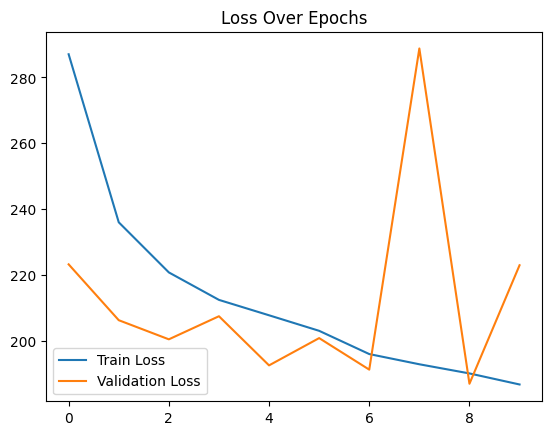

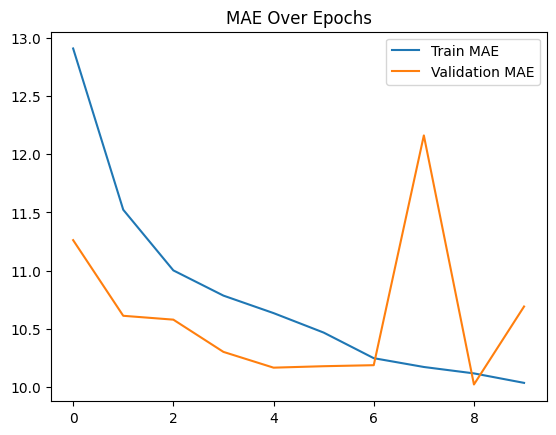

In [12]:
# Plot Loss and MAE
plt.plot(hist.history["loss"], label="Train Loss")
plt.plot(hist.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

plt.plot(hist.history["mae"], label="Train MAE")
plt.plot(hist.history["val_mae"], label="Validation MAE")
plt.legend()
plt.title("MAE Over Epochs")
plt.show()

In [13]:
# Evaluate Model
results = model.evaluate(x_test, y_test)
print("Test Loss and MAE: ", results)

149/149 [==============================] - 5s 25ms/step - loss: 223.3960 - mae: 10.6160
Test Loss and MAE:  [223.39601135253906, 10.616036415100098]


In [14]:
# Predict on a Sample Image
def predict_age(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (48, 48)) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    predicted_age = model.predict(img)
    return predicted_age[0][0]

# Example Usage
sample_image = "../dataset/UTKFace/1_0_2_20161219141817185.jpg.chip.jpg"
predicted_age = predict_age(sample_image, model)
print("Predicted Age: ", int(predicted_age))

1/1 [==============================] - 1s 588ms/step
Predicted Age:  1


In [16]:
model.save('../models/finetuned_model1.h5')